# Correlation Between Sensor

In [2]:
import pickle
import re
from pathlib import Path

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
from mne_connectivity import envelope_correlation
from IPython.display import clear_output

## Correlation between sensors across classical frequency bands

In [2]:
frequencies = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'lowgamma': (30, 42)  
}

# Envelope Correlation
def get_connectivity(epochs,
                     frequencies: dict,
                     sfreq: float = 1000,
):
    def bp_gen(epochs, fmin, fmax, sfreq):
        for ts in epochs:
            yield mne.filter.filter_data(ts, sfreq=sfreq, l_freq=fmin, h_freq=fmax)
    
    # each segment in epochs is 1 second
    # To compute the connectivity, we want segments that its lenght is about 30 seconds (or a bit less)
    raw = np.hstack(epochs.get_data())
    epochs = np.array_split(raw, 10, axis=1)
    
    conns = {} 
    for bp in frequencies.keys():
        conn_obj = envelope_correlation(bp_gen(epochs, frequencies[bp][0], frequencies[bp][1], sfreq),
                                               orthogonalize='pairwise')
        conn = conn_obj.combine()
        conn = conn.get_data(output='dense')[..., 0]
        conns[bp] = conn
        
    return conns

### Inspect the effect of Laplacian Surface filter

In [ ]:
path = sorted(Path('data/clean_data').glob('*.fif'))[11]

# open epochs
epochs = mne.read_epochs(path, preload=True)

# set montage
montage = mne.channels.make_standard_montage('standard_1020')
epochs.set_montage(montage)
    
# surface laplacian
# epochs_csd = mne.preprocessing.compute_current_source_density(epochs)

# compute connectivity
conn_without_laplacian = get_connectivity(epochs, frequencies)

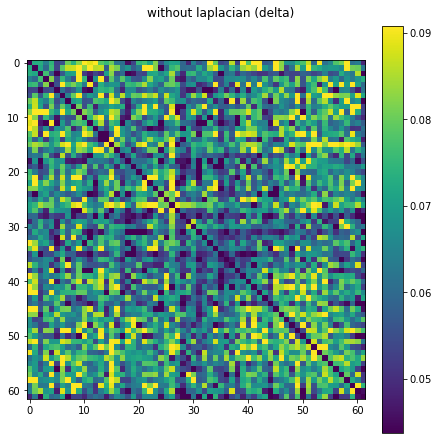

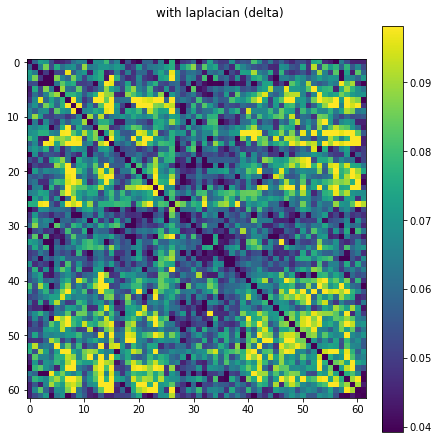

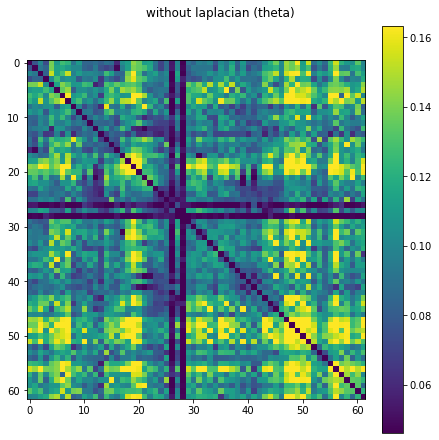

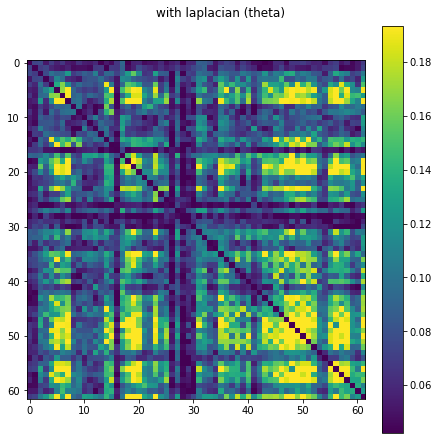

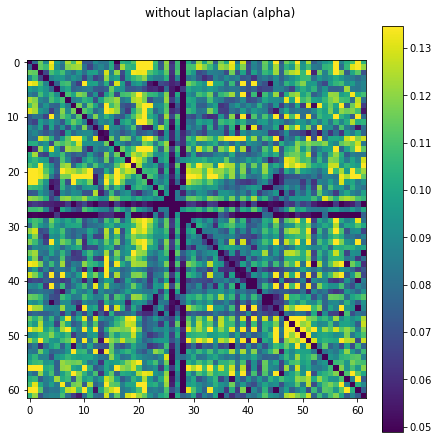

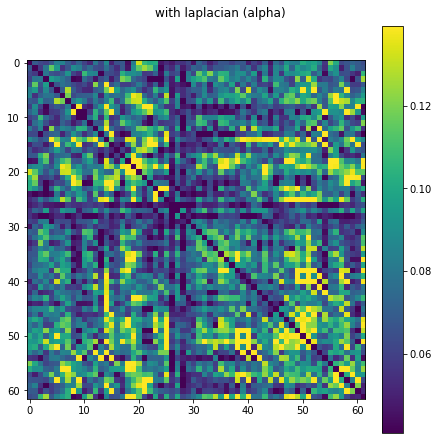

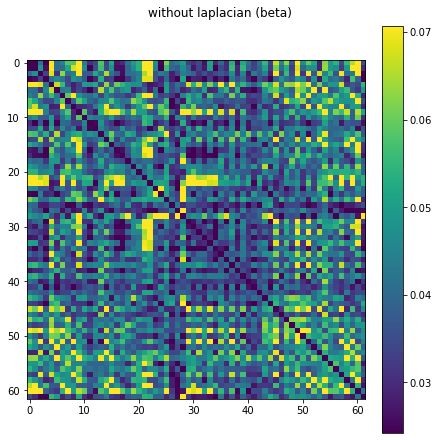

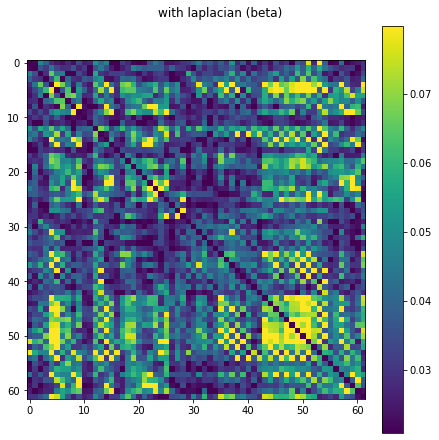

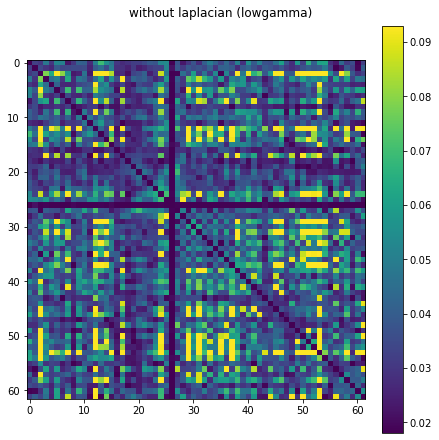

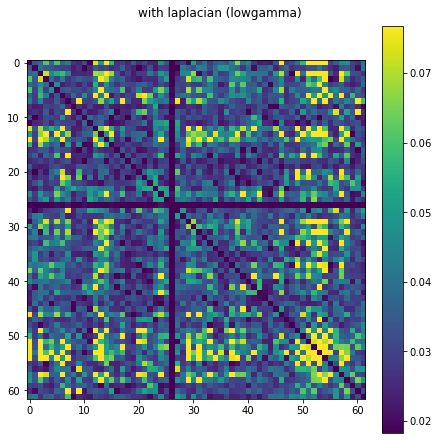

In [21]:
def plot_corr(corr, title):
        fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
        shw = ax.imshow(corr, cmap='viridis', clim=np.percentile(corr, [5, 95]))
        fig.suptitle(title)
        plt.colorbar(shw)

for key in frequencies.keys():
    plot_corr(conn_without_laplacian[key], f'without laplacian ({key})')
    plot_corr(conn[key], f'with laplacian ({key})')

### Copmute Correlation Connectivity

In [5]:
for subject_path in sorted(Path('data/clean_data').glob('*.fif')):
    subject, task = re.search('(.*)_ses-01_task-(.*)_proc-clean_epo', subject_path.name).groups()
    
    connectivity_path = f'data/connectivities/correlation_sensor/{subject}_task-{task}_conn-corr_sensor_filtered.pkl'
    if Path(connectivity_path).exists():
        continue
    
    print('>>>>>>>>', subject, task)
    if task == 'baseline2' or 'induction' in task:
        continue

    # open epochs
    epochs = mne.read_epochs(subject_path, preload=True)
    
    # set montage
    montage = mne.channels.make_standard_montage('standard_1020')
    epochs.set_montage(montage)
      
    # surface laplacian
    epochs_csd = mne.preprocessing.compute_current_source_density(epochs)
    
    # compute connectivity
    conn = get_connectivity(epochs_csd, frequencies)

    # save connectivity
    with open(connectivity_path, 'wb') as f:
        pickle.dump(conn, f)
        
    clear_output()

>>>>>>>> sub-52 induction1
>>>>>>>> sub-52 induction4


### Create Dataset

In [86]:
# index of the unwanted channels
ch_idx = np.where(np.isin(epochs.ch_names, ['M1', 'M2', 'EOG1', 'EOG2', 'ECG']))[0]
ch_names = np.delete(epochs.ch_names, ch_idx)

# create connectivity labels
conn_labels = pd.DataFrame(columns=ch_names, index=ch_names)
conn_labels = conn_labels.apply(lambda x: x.index + ' \N{left right arrow} ' + x.name)
conn_labels = conn_labels.values[np.triu_indices(conn_labels.shape[0], k=0)]

# self connections
identicals_col = [f'{i} \N{left right arrow} {i}' for i in ch_names]

# remove identical columns
conn_labels = np.delete(conn_labels, np.where(np.isin(conn_labels, identicals_col))[0])

In [87]:
# initiate an empty df
conn_df_total = pd.DataFrame()

# open data
for subject_path in sorted(Path('data/connectivities/correlation_sensor/').glob('*.pkl')):
  
  subject, task = re.search('(.*)_task-(.*)_conn-corr_sensor_filtered.*', subject_path.stem).groups()
  
  if task == 'baseline2' or 'induction' in task:
    continue
    
  with open(subject_path, 'rb') as f:
    conns = pickle.load(f)
  
  conn_df = pd.DataFrame()
  for freq, conn in conns.items():
    
    # remove unwanted connections
    conn = np.delete(conn, ch_idx, axis=0)
    conn = np.delete(conn, ch_idx, axis=1)
  
    conn_flat = conn[np.triu_indices(conn.shape[-1], k=1)]
    freq_labels = conn_labels + f' ({freq})'
    conn_df_ = pd.DataFrame(conn_flat, index=freq_labels, columns=[0]).transpose()
    conn_df = conn_df.join(conn_df_, how='outer')

  conn_df_total = pd.concat([conn_df_total, conn_df], axis=0)

subjects = [f'{i:02}' for i in range(1, 53)]
tasks = [
'baseline1',
'experience1',
'experience2',
'experience3',
'experience4'
  ]    
# set index
index = []
[index.append(sub + '_' + cond) for sub in subjects for cond in tasks ]
[index.remove(i) for i in ['52_experience2', '52_experience3']]
conn_df_total = conn_df_total.set_axis(index)

In [89]:
# open behavioral data and ids map
bh = pd.read_csv('docs/plb_hyp_data.csv', index_col='index')
ids_map = pd.read_excel('docs/ids_map.xlsx', header=1, index_col='behavioral_id')
ids_map = ids_map.drop_duplicates('bids_id')
ids_map = ids_map[['bids_id']]
ids_map['bids_id'] = ids_map['bids_id'].apply(lambda x:str(x).zfill(2))
bh = bh.join(ids_map, how='right')
bh = bh.melt(
    id_vars=['procedure_type_1', 'procedure_type_2', 'procedure_type_3', 'procedure_type_4', 'bids_id',
             'description_type_1', 'description_type_2', 'description_type_3', 'description_type_4'],
    value_vars=['hypnosis_depth_1', 'hypnosis_depth_2', 'hypnosis_depth_3', 'hypnosis_depth_4'])
bh['session'] = bh['variable'].apply(lambda x:x.split('_')[2])
bh['procedure'] = bh.apply(lambda r: r['procedure_type_'+r['session']], axis=1)
bh['description'] = bh.apply(lambda r: r['description_type_'+r['session']], axis=1)
bh = bh[['bids_id', 'value', 'procedure', 'description', 'session']].sort_values(by=['bids_id', 'session']).set_index('bids_id')
bh = bh.rename(columns={'value':'hypnosis_depth'})
bh.reset_index(inplace=True)

conn_df_total[['bids_id', 'condition']] = conn_df_total.index.to_series().apply(lambda x:x.split('_')).apply(pd.Series)
conn_df_total['session'] = conn_df_total['condition'].apply(lambda x:x[-1])
conn_df_total.reset_index(drop=True, inplace=True)
conn_df_total = pd.merge(bh, conn_df_total, how='right', on=['session', 'bids_id'], right_index=False)
conn_df_total = conn_df_total.sort_values(by=['bids_id', 'session', 'condition']).reset_index(drop=True)
conn_df_total.insert(1, 'condition', conn_df_total.pop('condition'))
conn_df_total.head()

,bids_id,condition,hypnosis_depth,procedure,description,session,Fp1 ↔ Fp2 (delta),Fp1 ↔ F3 (delta),Fp1 ↔ F4 (delta),Fp1 ↔ C3 (delta),...,P5 ↔ P6 (lowgamma),P5 ↔ PO3 (lowgamma),P5 ↔ PO4 (lowgamma),P5 ↔ FCz (lowgamma),P6 ↔ PO3 (lowgamma),P6 ↔ PO4 (lowgamma),P6 ↔ FCz (lowgamma),PO3 ↔ PO4 (lowgamma),PO3 ↔ FCz (lowgamma),PO4 ↔ FCz (lowgamma)
0,01,baseline1,6.0,whitenoise,hypnosis,1,0.100862,0.057978,0.085338,0.071738,...,0.045214,0.034737,0.025457,0.035510,0.025035,0.050114,0.045798,0.016695,0.037255,0.029768
1,01,experience1,6.0,whitenoise,hypnosis,1,0.092203,0.096538,0.052435,0.075540,...,0.054219,0.048643,0.034474,0.044839,0.041507,0.029700,0.044820,0.042458,0.047801,0.025581
2,01,experience2,7.0,relaxation,control,2,0.083558,0.070564,0.052568,0.044928,...,0.019888,0.044103,0.032200,0.023063,0.037049,0.033753,0.026219,0.029443,0.033139,0.030696
3,01,experience3,8.0,confusion,hypnosis,3,0.065466,0.066404,0.071360,0.079574,...,0.025489,0.047471,0.028745,0.019876,0.036167,0.033325,0.029120,0.026965,0.020463,0.026357
4,01,experience4,1.0,embedded,control,4,0.237852,0.257821,0.215842,0.229276,...,0.043252,0.060153,0.071372,0.060786,0.064435,0.072622,0.092168,0.061753,0.073391,0.089530


In [92]:
conn_df_total.to_csv('data/classification_datasets/correlation_sensor.csv')